In [83]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, filtfilt

# Capture data

In [3]:
with open('cached_EEG.pkl', 'rb') as f:
    eeg_df = pickle.load(f)

In [4]:
eeg_df.head(5)

,EEG,Max_Time
0,0.0,0.000
1,5987.1,1.953
2,5966.0,3.906
3,5950.1,5.859
4,5922.5,7.812


In [15]:
eeg_signal = eeg_df['EEG'].to_numpy()
time_stamps = eeg_df['Max_Time'].to_numpy()

Run a high pass filter to exclude all frequencies below 1Hz

In [17]:
def butter_highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

filtered_signal = butter_highpass_filter(eeg_signal, 1, 250)

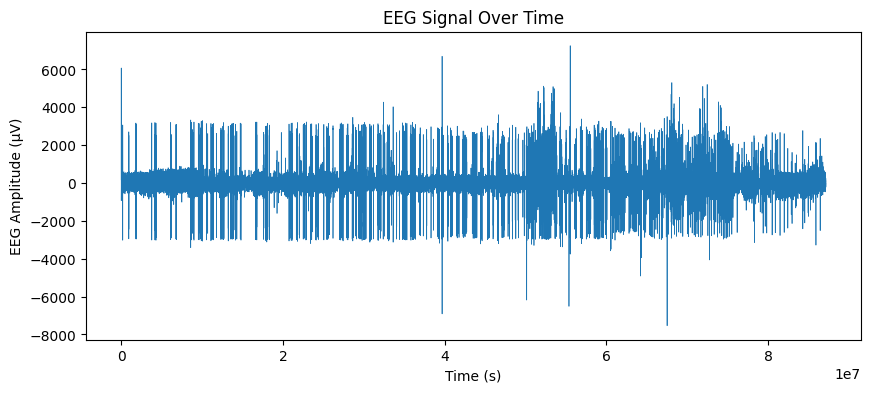

In [81]:
plt.figure(figsize=(10, 4))
plt.plot(time_stamps, filtered_signal, linewidth=0.5)  # Convert ms to seconds for readability
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal Over Time")
plt.show()

Segment our data into 5 second intervals

In [76]:
SEGMENTATION_LENGTH = 2560
NUM_SAMPLES = len(filtered_signal)
TRIMMED_LENGTH = NUM_SAMPLES % SEGMENTATION_LENGTH
NUMBER_OF_SEGMENTATIONS = NUM_SAMPLES // SEGMENTATION_LENGTH
trimmed_signal = filtered_signal[TRIMMED_LENGTH:]
trimmed_time_stamps = time_stamps[TRIMMED_LENGTH:]
np.shape(trimmed_signal)

(44620800,)

In [112]:
segmented_signal = trimmed_signal.reshape((NUMBER_OF_SEGMENTATIONS, SEGMENTATION_LENGTH))
segmented_time_stamps = trimmed_time_stamps.reshape((NUMBER_OF_SEGMENTATIONS, SEGMENTATION_LENGTH))
np.shape(segmented_signal)
np.shape(segmented_time_stamps)

(17430, 2560)

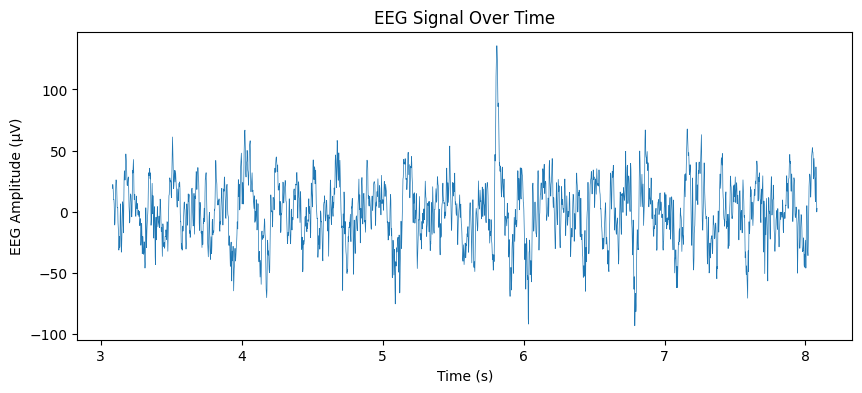

In [80]:
plt.figure(figsize=(10, 4))
plt.plot(segmented_time_stamps[0] / 1000, segmented_signal[0], linewidth=0.5)  # Convert ms to seconds for readability
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal Over Time")
plt.show()

DWT Decomposition

C:\Users\alexa\AppData\Local\Temp\ipykernel_40032\2949947632.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\alexa\AppData\Local\Temp\ipykernel_40032\2949947632.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


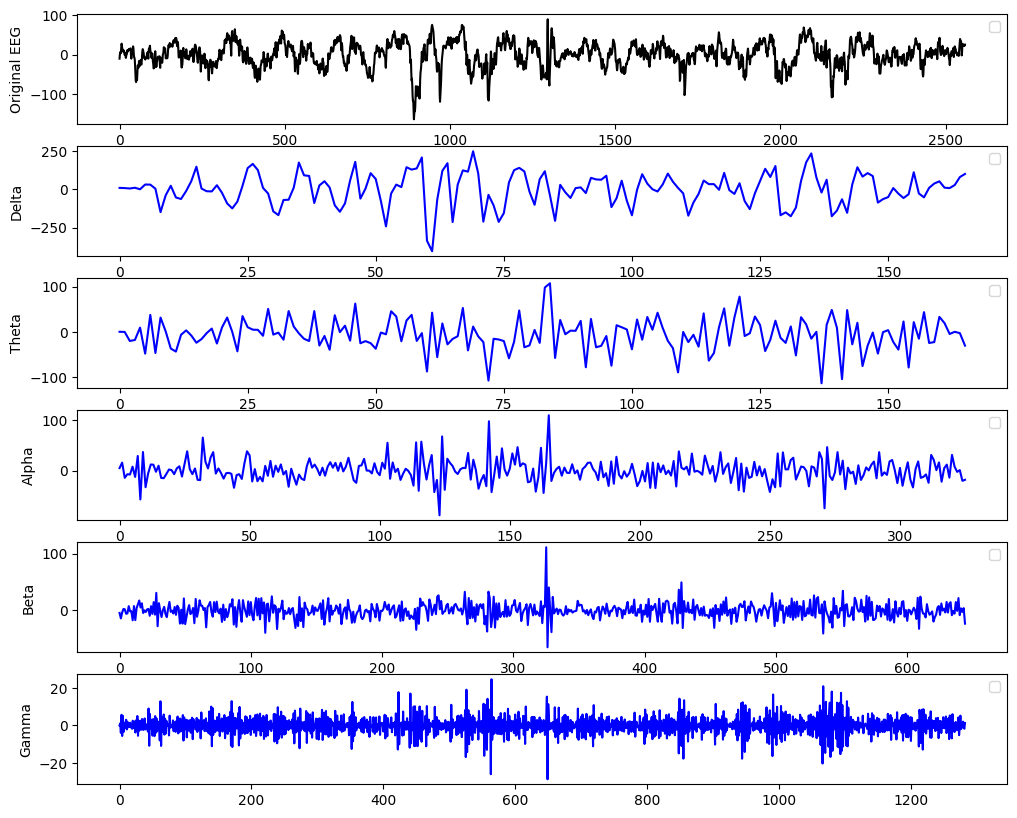

In [116]:
WAVELET = 'db4'
LEVEL = 4
SAMPLE_INDEX = 1000
WAVELET_MAP = {
    2: "Delta",
    3: "Theta",
    4: "Alpha",
    5: "Beta",
    6: "Gamma"
}
def wave_decomposition(data, wavelet=WAVELET, level=LEVEL):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs

def plot_wavelets(data, cDs):
    plt.figure(figsize=(12, 10))
    plt.subplot(6, 1, 1)
    plt.plot(data, color='black')
    plt.ylabel("Original EEG")
    plt.legend()

    for i, cD in enumerate(cDs, 2):
        plt.subplot(6, 1, i)
        plt.plot(cD, color='blue')
        plt.ylabel(WAVELET_MAP[i])
        plt.legend()
    plt.show()

test_coefficients = wave_decomposition(segmented_signal[SAMPLE_INDEX])
plot_wavelets(segmented_signal[SAMPLE_INDEX], test_coefficients)